In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
# nltk.download('stopwords') # Chạy lần đầu nếu chưa tải
from nltk.corpus import stopwords

# Tắt các cảnh báo không cần thiết (tùy chọn)
import warnings
warnings.filterwarnings('ignore')



In [2]:
# 1. Đọc dữ liệu
# Dataset này thường cần encoding='latin-1' hoặc 'ISO-8859-1'
try:
    df = pd.read_csv('../data/raw/spam.csv', encoding='latin-1')
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file spam.csv trong thư mục data/raw/")
    # Dừng hoặc xử lý lỗi tại đây
    exit() # Hoặc cách xử lý khác

print("Đọc dữ liệu thành công!")
print("5 dòng đầu tiên:")
print(df.head())



Đọc dữ liệu thành công!
5 dòng đầu tiên:
  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...


In [3]:
# 2. Tiền xử lý cột và kiểm tra dữ liệu thiếu
# Thường dataset này có 5 cột, chỉ cần 2 cột đầu
df = df[['Category', 'Message']]

df.rename(columns={'v1': 'Category', 'v2': 'Message'}, inplace=True)

print("\nThông tin DataFrame sau khi xử lý cột:")
df.info()

print("\nKiểm tra dữ liệu thiếu:")
print(df.isnull().sum())

# Chuyển đổi nhãn sang dạng số (ví dụ: ham=0, spam=1) - tiện cho mô hình sau này
df['Category_Num'] = df['Category'].map({'ham': 0, 'spam': 1})
print("\n5 dòng đầu sau khi thêm cột Category_Num:")
print(df.head())

# Lưu lại phiên bản này nếu muốn (tùy chọn)



Thông tin DataFrame sau khi xử lý cột:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB

Kiểm tra dữ liệu thiếu:
Category    0
Message     0
dtype: int64

5 dòng đầu sau khi thêm cột Category_Num:
  Category                                            Message  Category_Num
0      ham  Go until jurong point, crazy.. Available only ...             0
1      ham                      Ok lar... Joking wif u oni...             0
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...             1
3      ham  U dun say so early hor... U c already then say...             0
4      ham  Nah I don't think he goes to usf, he lives aro...             0


In [4]:
df.to_csv('../data/processed/spam_cleaned_columns.csv', index=False)


Phân bố lớp Spam/Ham:
Category
ham     4825
spam     747
Name: count, dtype: int64


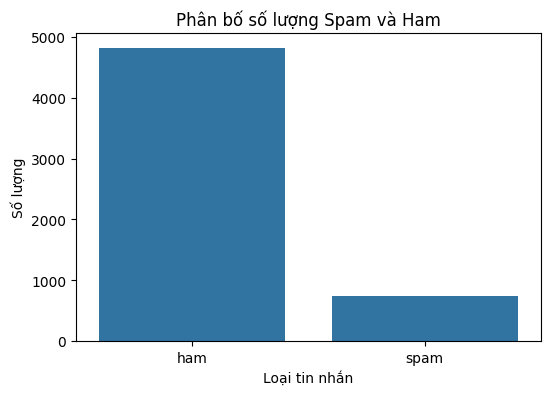

In [5]:
# 3. EDA Cơ bản

# Phân bố lớp (Spam vs. Ham)
print("\nPhân bố lớp Spam/Ham:")
print(df['Category'].value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(x='Category', data=df)
plt.title('Phân bố số lượng Spam và Ham')
plt.xlabel('Loại tin nhắn')
plt.ylabel('Số lượng')
# Lưu biểu đồ (nếu muốn)
plt.savefig('../results/figures/class_distribution.png')
plt.show()





Thống kê độ dài tin nhắn:
count    5572.000000
mean       80.494975
std        60.000375
min         2.000000
25%        36.000000
50%        61.000000
75%       122.000000
max       910.000000
Name: Message_Length, dtype: float64


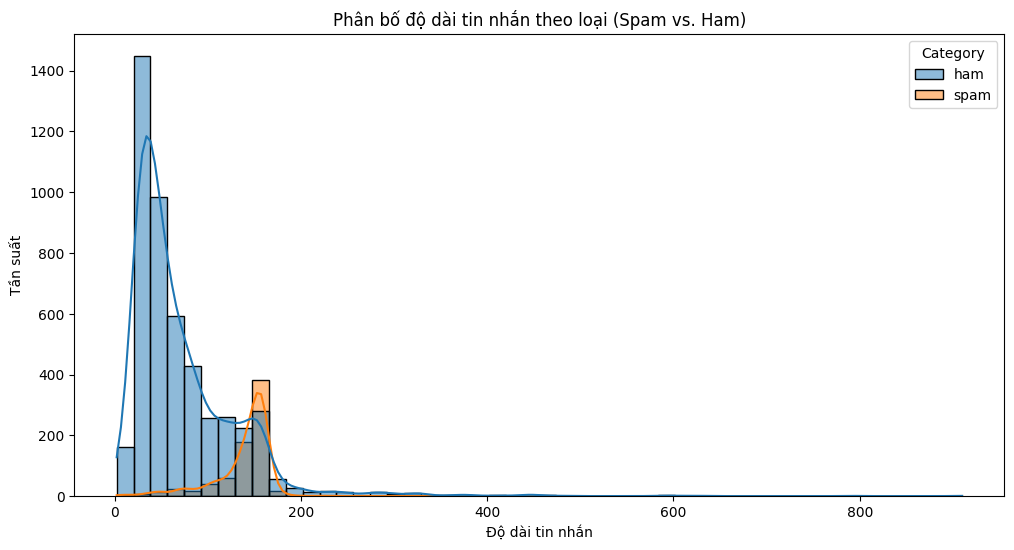

In [6]:
# Phân tích độ dài tin nhắn
df['Message_Length'] = df['Message'].apply(len)
print("\nThống kê độ dài tin nhắn:")
print(df['Message_Length'].describe())

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Message_Length', hue='Category', kde=True, bins=50)
plt.title('Phân bố độ dài tin nhắn theo loại (Spam vs. Ham)')
plt.xlabel('Độ dài tin nhắn')
plt.ylabel('Tần suất')
# plt.savefig('../results/figures/length_distribution.png')
plt.show()



In [7]:
# Xem xét các tin nhắn có độ dài bất thường (nếu cần)
print("\nTin nhắn dài nhất:")
print(df[df['Message_Length'] == df['Message_Length'].max()]['Message'].iloc[0])
print("\nTin nhắn ngắn nhất:")
print(df[df['Message_Length'] == df['Message_Length'].min()]['Message'].iloc[0])




Tin nhắn dài nhất:
For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later..

Tin nhắn ngắn nhất:
Ok


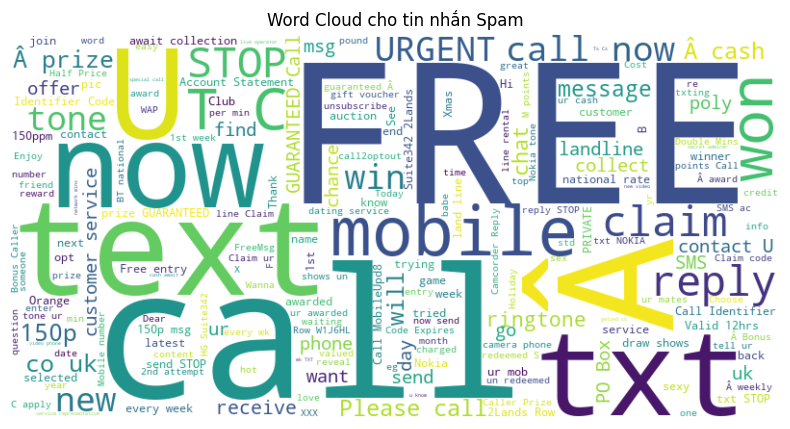

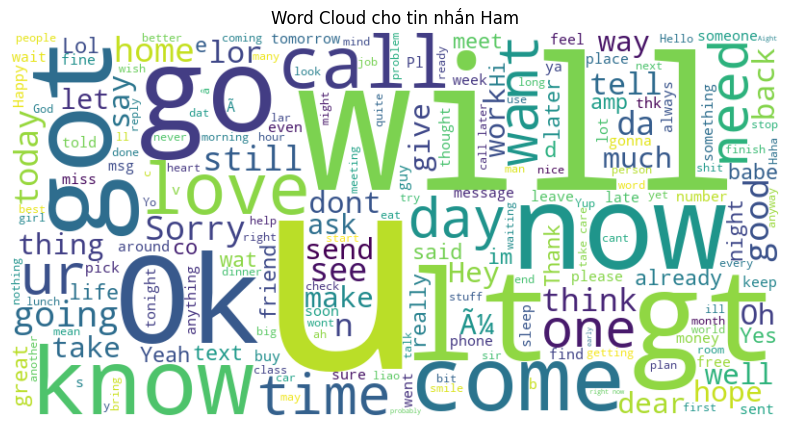

In [8]:
# (Tùy chọn) Word Cloud
try:
    from wordcloud import WordCloud

    spam_text = " ".join(df[df['Category'] == 'spam']['Message'])
    ham_text = " ".join(df[df['Category'] == 'ham']['Message'])

    # Word cloud cho Spam
    plt.figure(figsize=(10, 5))
    wordcloud_spam = WordCloud(width=800, height=400, background_color='white').generate(spam_text)
    plt.imshow(wordcloud_spam, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud cho tin nhắn Spam')
    plt.savefig('../results/figures/wordcloud_spam.png')
    plt.show()

    # Word cloud cho Ham
    plt.figure(figsize=(10, 5))
    wordcloud_ham = WordCloud(width=800, height=400, background_color='white').generate(ham_text)
    plt.imshow(wordcloud_ham, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud cho tin nhắn Ham')
    plt.savefig('../results/figures/wordcloud_ham.png')
    plt.show()

except ImportError:
    print("\nThư viện wordcloud chưa được cài đặt. Bỏ qua bước tạo Word Cloud.")
    print("Để cài đặt, chạy: pip install wordcloud")

In [9]:
# 4. Áp dụng Pipeline tiền xử lý v1

# Import hàm từ file src (đảm bảo file nằm đúng cấu trúc)
import sys
sys.path.append('../src')
import os
from preprocess import clean_text_v1

# Thêm thư mục src vào đường dẫn để import
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


print("\nÁp dụng tiền xử lý v1...")
# Tạo cột mới chứa tin nhắn đã làm sạch
df['Cleaned_Message'] = df['Message'].apply(clean_text_v1)

print("5 dòng đầu với Cleaned_Message:")
print(df[['Message', 'Cleaned_Message']].head())

# Xem thử một vài kết quả
print("\nVí dụ tiền xử lý:")
for i in range(5):
    print(f"Gốc : {df['Message'].iloc[i]}")
    print(f"Sạch: {df['Cleaned_Message'].iloc[i]}\n")

# Lưu lại DataFrame đã xử lý nếu muốn
# df.to_csv('../data/processed/spam_preprocessed_v1.csv', index=False)

{"needn't", "she'd", 'aren', "couldn't", 'her', 'been', 'off', "hasn't", 'the', 'myself', "we'll", 'my', 'not', 'theirs', "he'd", 'how', "i'd", "mightn't", 'that', "they'd", "that'll", 'both', 'during', 'ain', 'wouldn', "i'm", 'their', 'same', 'at', 'mightn', 'those', 'were', "shan't", "doesn't", 't', 'are', 'do', 'hadn', "aren't", 'on', 'they', "it'll", 'while', 'no', 'very', 'so', 'him', 'with', 've', 'into', 'having', 'will', 'over', "you're", 'by', 'of', 'why', 'o', 're', 'wasn', 'am', 'there', "hadn't", 'when', 'did', 'again', 'most', 'shan', 'out', 'few', 'does', 'was', 'because', 'd', 'here', 'his', 'a', "she's", 'than', 'these', 'can', 'doing', 'too', 'or', "i've", 'he', 'should', 'doesn', "he'll", 'needn', 'herself', 'yourselves', 'it', "you'll", 'other', 'being', 'before', 'where', 'yourself', 'against', 'down', 'then', 'ours', 'to', "it's", 'in', 'we', "he's", 'haven', 'm', 'up', 'now', 'as', 'below', "they've", "we're", 'you', 'them', 'hers', 'such', 'mustn', 'didn', 'thems

In [10]:
# 5. Bắt đầu triển khai Random Forest (Baseline)

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("\nBắt đầu huấn luyện mô hình Random Forest...")

# df = pd.read_csv('../data/raw/spam.csv')

# df['Cleaned_Message'] = df['Message'].apply(clean_text_v1)
# df['Category_Num'] = df['Cleaned_Message'].apply(clean_text_v1)

# Dữ liệu đầu vào cho mô hình là cột Cleaned_Message
X = df['Cleaned_Message']
y = df['Category_Num'] # Nhãn dạng số (0 hoặc 1)

# Chia dữ liệu Train/Test (Tỷ lệ 80/20)
# Dùng random_state=42 để cả nhóm có kết quả chia giống nhau
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Kích thước tập huấn luyện: {X_train.shape[0]}")
print(f"Kích thước tập kiểm tra: {X_test.shape[0]}")

# Khởi tạo TF-IDF Vectorizer
# max_features giới hạn số lượng từ trong từ điển (tùy chọn, giúp giảm chiều dữ liệu)
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Bạn có thể thử nghiệm giá trị khác

# Fit và transform tập huấn luyện
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Chỉ transform tập kiểm tra (dùng từ điển đã học từ tập train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\nKích thước ma trận TF-IDF tập huấn luyện: {X_train_tfidf.shape}")
print(f"Kích thước ma trận TF-IDF tập kiểm tra: {X_test_tfidf.shape}")

# Khởi tạo và huấn luyện mô hình Random Forest
rdf_model = RandomForestClassifier()
rdf_model.fit(X_train_tfidf, y_train)

print("\nĐã huấn luyện xong mô hình Random Forest.")

# Dự đoán trên tập kiểm tra
y_pred_nb = rdf_model.predict(X_test_tfidf)

# Đánh giá ban đầu
print("\nKết quả đánh giá Random Forest (Baseline):")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb, target_names=['ham', 'spam']))

# (Tùy chọn) Lấy xác suất
# y_pred_proba_nb = nb_model.predict_proba(X_test_tfidf)
# print("\nXác suất dự đoán cho 5 mẫu đầu tiên:\n", y_pred_proba_nb[:5])


Bắt đầu huấn luyện mô hình Random Forest...
Kích thước tập huấn luyện: 4457
Kích thước tập kiểm tra: 1115

Kích thước ma trận TF-IDF tập huấn luyện: (4457, 5000)
Kích thước ma trận TF-IDF tập kiểm tra: (1115, 5000)

Đã huấn luyện xong mô hình Random Forest.

Kết quả đánh giá Random Forest (Baseline):
Accuracy: 0.9775784753363229

Confusion Matrix:
 [[965   1]
 [ 24 125]]

Classification Report:
               precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.99      0.84      0.91       149

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [11]:
from sklearn.model_selection import GridSearchCV
import joblib

In [12]:
# --- (Tùy chọn) Lưu mô hình và vectorizer ---
print("\nĐang lưu mô hình và vectorizer...")
output_dir = '../results/trained_models/'
os.makedirs(output_dir, exist_ok=True) # Tạo thư mục nếu chưa có
joblib.dump(tfidf_vectorizer, os.path.join(output_dir, 'tfidf_vectorizer.pkl'))
print("Đã lưu mô hình và vectorizer vào thư mục results/trained_models/")


Đang lưu mô hình và vectorizer...
Đã lưu mô hình và vectorizer vào thư mục results/trained_models/


In [13]:
# -*- coding: utf-8 -*-
# Cell mới: Tạo Test Case và Dự đoán bằng mô hình Random Forest đã huấn luyện

# --- Giả định các biến sau đã tồn tại từ cell trước ---
# 
# tfidf_vectorizer: Đối tượng TfidfVectorizer đã được .fit_transform() trên tập train
# clean_text_v1: Hàm tiền xử lý văn bản đã được định nghĩa hoặc import

# --- Định nghĩa các tin nhắn mới cần dự đoán ---
new_messages_for_test = [
    "URGENT! Claim your FREE £1000 prize now! Click http://spamlink.com", # Tin nhắn có vẻ là SPAM
    "Hey, wondering if you're free for coffee later today?", # Tin nhắn có vẻ là HAM
    "Meet singles in your area, text DATE to 88888 T&Cs apply 18+", # Tin nhắn có vẻ là SPAM
    "Remember to buy bread and eggs on your way back.", # Tin nhắn có vẻ là HAM
    "Limited time offer! Exclusive discount just for you!", # Tin nhắn có vẻ là SPAM
    "50 percent discount this Friday only!"
]

print("--- Bắt đầu Test Case ---")
print(f"Số lượng tin nhắn thử nghiệm: {len(new_messages_for_test)}")

# --- 1. Tiền xử lý các tin nhắn mới ---
# Áp dụng hàm tiền xử lý đã có (cần đảm bảo hàm clean_text_v1 đã được định nghĩa/import ở cell trước)
try:
    cleaned_test_messages = [clean_text_v1(msg) for msg in new_messages_for_test]
    print("\nTin nhắn sau khi tiền xử lý:")
    for i, msg in enumerate(cleaned_test_messages):
        print(f"{i+1}: {msg}")
except NameError:
    print("\nLỗi: Hàm 'clean_text_v1' chưa được định nghĩa hoặc import.")
    print("Vui lòng chạy cell định nghĩa/import hàm này trước.")
    # Dừng thực thi cell này nếu hàm chưa có
    raise

# --- 2. Vector hóa các tin nhắn mới ---
# *** Quan trọng: Dùng đối tượng tfidf_vectorizer đã fit từ cell trước, chỉ gọi .transform() ***
try:
    new_messages_tfidf_test = tfidf_vectorizer.transform(cleaned_test_messages)
    print(f"\nĐã vector hóa {len(cleaned_test_messages)} tin nhắn thành ma trận TF-IDF kích thước: {new_messages_tfidf_test.shape}")
except NameError:
    print("\nLỗi: Biến 'tfidf_vectorizer' chưa được định nghĩa.")
    print("Vui lòng chạy cell huấn luyện TF-IDF Vectorizer trước.")
    raise

# --- 3. Dự đoán ---
print("\nĐang thực hiện dự đoán bằng mô hình Random Forest...")
try:
    # Dự đoán nhãn (0 hoặc 1)
    predictions_test = rdf_model.predict(new_messages_tfidf_test)
    # Dự đoán xác suất (P(ham), P(spam))
    # Lưu ý: rdforest_model phải được khởi tạo với probability=True ở cell huấn luyện
    probabilities_test = rdf_model.predict_proba(new_messages_tfidf_test)
except NameError:
    print("\nLỗi: Biến 'rdforest_model' chưa được định nghĩa.")
    print("Vui lòng chạy cell huấn luyện mô hình SVM trước.")
    raise
except AttributeError:
     print("\nLỗi: Không thể lấy xác suất.")
     print("Để dùng predict_proba(), mô hình SVM cần được khởi tạo với tham số 'probability=True'.")
     # Gán giá trị mặc định để code không bị lỗi tiếp
     probabilities_test = np.array([[0.5, 0.5]] * len(predictions_test)) # Tạo mảng xác suất giả định

# --- 4. Hiển thị kết quả ---
print("\n--- Kết quả Dự đoán Test Case ---")
label_map = {0: 'ham', 1: 'spam'} # Ánh xạ nhãn số về chữ

for i, original_message in enumerate(new_messages_for_test):
    predicted_label_num = predictions_test[i]
    predicted_label_text = label_map[predicted_label_num]
    prob_ham = probabilities_test[i][0] # Xác suất là ham (lớp 0)
    prob_spam = probabilities_test[i][1] # Xác suất là spam (lớp 1)

    print(f"\nTin nhắn gốc : \"{original_message}\"")
    # print(f"Tin nhắn sạch: \"{cleaned_test_messages[i]}\"") # Bỏ comment nếu muốn xem
    print(f"  -> Dự đoán   : {predicted_label_text.upper()}")
    # Chỉ in xác suất nếu lấy được
    if 'AttributeError' not in locals() or not isinstance(locals()['AttributeError'], AttributeError):
         print(f"  -> Xác suất : [Ham={prob_ham:.4f}, Spam={prob_spam:.4f}]")

print("\n--- Hoàn thành Test Case ---")

--- Bắt đầu Test Case ---
Số lượng tin nhắn thử nghiệm: 6

Tin nhắn sau khi tiền xử lý:
1: urgent claim free 1000 prize click httpspamlinkcom
2: hey wondering youre free coffee later today
3: meet singles area text date 88888 tcs apply 18
4: remember buy bread eggs way back
5: limited time offer exclusive discount
6: 50 percent discount friday

Đã vector hóa 6 tin nhắn thành ma trận TF-IDF kích thước: (6, 5000)

Đang thực hiện dự đoán bằng mô hình Random Forest...

--- Kết quả Dự đoán Test Case ---

Tin nhắn gốc : "URGENT! Claim your FREE £1000 prize now! Click http://spamlink.com"
  -> Dự đoán   : SPAM
  -> Xác suất : [Ham=0.2700, Spam=0.7300]

Tin nhắn gốc : "Hey, wondering if you're free for coffee later today?"
  -> Dự đoán   : HAM
  -> Xác suất : [Ham=0.9500, Spam=0.0500]

Tin nhắn gốc : "Meet singles in your area, text DATE to 88888 T&Cs apply 18+"
  -> Dự đoán   : SPAM
  -> Xác suất : [Ham=0.3100, Spam=0.6900]

Tin nhắn gốc : "Remember to buy bread and eggs on your way back."
  

In [14]:
print("Bắt đầu tinh chỉnh siêu tham số cho Random Forest")

# 1. Define parameters grid
param_grid_rdf = {
  'n_estimators': [100, 200],        # Số lượng cây trong rừng
    'max_depth': [None, 10, 20],        # Độ sâu tối đa của cây
    'min_samples_split': [2, 5],        # Số mẫu tối thiểu để chia một node
    'min_samples_leaf': [1, 2],          # Số mẫu tối thiểu ở một lá
    'bootstrap': [True]              # Có sử dụng bootstrap mẫu hay không
}

# 2. Init GridSearchCV
grid_search_rdf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid_rdf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

# 3. Fit GridSearchCV into training data
print("Running GridSearchCV on RDF...")
grid_search_rdf.fit(X_train_tfidf, y_train)

# 4. Take out the best parameters and scores
print("\nTham số tốt nhất tìm được cho RDF:")
print(grid_search_rdf.best_params_)
print(f"Điểm F1 (cross-validation) tốt nhất cho SVM: {grid_search_rdf.best_score_:.4f}")

# 5. Lấy mô hình SVM tốt nhất
best_rdf_model = grid_search_rdf.best_estimator_

# 6. Đánh giá mô hình SVM tốt nhất trên tập Test
print("\nĐánh giá mô hình Random Forest tốt nhất trên tập Test:")
y_pred_rdf_tuned = best_rdf_model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred_rdf_tuned))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rdf_tuned))
print("\nClassification Report (RDF Tuned):\n", classification_report(y_test, y_pred_rdf_tuned, target_names=['ham', 'spam']))

# (Tùy chọn) Lưu mô hình Random Forest tốt nhất

Bắt đầu tinh chỉnh siêu tham số cho Random Forest
Running GridSearchCV on RDF...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Tham số tốt nhất tìm được cho RDF:
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Điểm F1 (cross-validation) tốt nhất cho SVM: 0.9167

Đánh giá mô hình Random Forest tốt nhất trên tập Test:
Accuracy: 0.9829596412556054

Confusion Matrix:
 [[966   0]
 [ 19 130]]

Classification Report (RDF Tuned):
               precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       1.00      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [15]:
output_dir = '../results/trained_models/'
os.makedirs(output_dir, exist_ok=True)
joblib.dump(best_rdf_model, os.path.join(output_dir, 'best_rdf_model.pkl'))
print("Đã lưu mô hình Random Forest tốt nhất.")

Đã lưu mô hình Random Forest tốt nhất.


In [16]:
new_messages_for_test = [
    "URGENT! Claim your FREE £1000 prize now! Click http://spamlink.com", # Tin nhắn có vẻ là SPAM
    "Hey, wondering if you're free for coffee later today?", # Tin nhắn có vẻ là HAM
    "Meet singles in your area, text DATE to 88888 T&Cs apply 18+", # Tin nhắn có vẻ là SPAM
    "Remember to buy bread and eggs on your way back.", # Tin nhắn có vẻ là HAM
    "Limited time offer! Exclusive discount just for you!", # Tin nhắn có vẻ là SPAM
    "50 percent discount this Friday only!"
]

print("--- Bắt đầu Test Case ---")
print(f"Số lượng tin nhắn thử nghiệm: {len(new_messages_for_test)}")

# --- 1. Tiền xử lý các tin nhắn mới ---
# Áp dụng hàm tiền xử lý đã có (cần đảm bảo hàm clean_text_v1 đã được định nghĩa/import ở cell trước)
try:
    cleaned_test_messages = [clean_text_v1(msg) for msg in new_messages_for_test]
    print("\nTin nhắn sau khi tiền xử lý:")
    for i, msg in enumerate(cleaned_test_messages):
        print(f"{i+1}: {msg}")
except NameError:
    print("\nLỗi: Hàm 'clean_text_v1' chưa được định nghĩa hoặc import.")
    print("Vui lòng chạy cell định nghĩa/import hàm này trước.")
    # Dừng thực thi cell này nếu hàm chưa có
    raise

# --- 2. Vector hóa các tin nhắn mới ---
# *** Quan trọng: Dùng đối tượng tfidf_vectorizer đã fit từ cell trước, chỉ gọi .transform() ***
try:
    new_messages_tfidf_test = tfidf_vectorizer.transform(cleaned_test_messages)
    print(f"\nĐã vector hóa {len(cleaned_test_messages)} tin nhắn thành ma trận TF-IDF kích thước: {new_messages_tfidf_test.shape}")
except NameError:
    print("\nLỗi: Biến 'tfidf_vectorizer' chưa được định nghĩa.")
    print("Vui lòng chạy cell huấn luyện TF-IDF Vectorizer trước.")
    raise

# --- 3. Dự đoán ---
print("\nĐang thực hiện dự đoán bằng mô hình SVM...")
try:
    # Dự đoán nhãn (0 hoặc 1)
    predictions_test = rdf_model.predict(new_messages_tfidf_test)
    # Dự đoán xác suất (P(ham), P(spam))
    # Lưu ý: 
    # 
    # 
    # 
    #  phải được khởi tạo với probability=True ở cell huấn luyện
    probabilities_test = best_rdf_model.predict_proba(new_messages_tfidf_test)
except NameError:
    print("\nLỗi: Biến 'rdf_model' chưa được định nghĩa.")
    print("Vui lòng chạy cell huấn luyện mô hình SVM trước.")
    raise
except AttributeError:
     print("\nLỗi: Không thể lấy xác suất.")
     print("Để dùng predict_proba(), mô hình SVM cần được khởi tạo với tham số 'probability=True'.")
     # Gán giá trị mặc định để code không bị lỗi tiếp
     probabilities_test = np.array([[0.5, 0.5]] * len(predictions_test)) # Tạo mảng xác suất giả định

# --- 4. Hiển thị kết quả ---
print("\n--- Kết quả Dự đoán Test Case ---")
label_map = {0: 'ham', 1: 'spam'} # Ánh xạ nhãn số về chữ

for i, original_message in enumerate(new_messages_for_test):
    predicted_label_num = predictions_test[i]
    predicted_label_text = label_map[predicted_label_num]
    prob_ham = probabilities_test[i][0] # Xác suất là ham (lớp 0)
    prob_spam = probabilities_test[i][1] # Xác suất là spam (lớp 1)

    print(f"\nTin nhắn gốc : \"{original_message}\"")
    # print(f"Tin nhắn sạch: \"{cleaned_test_messages[i]}\"") # Bỏ comment nếu muốn xem
    print(f"  -> Dự đoán   : {predicted_label_text.upper()}")
    # Chỉ in xác suất nếu lấy được
    if 'AttributeError' not in locals() or not isinstance(locals()['AttributeError'], AttributeError):
         print(f"  -> Xác suất : [Ham={prob_ham:.4f}, Spam={prob_spam:.4f}]")

print("\n--- Hoàn thành Test Case ---")

--- Bắt đầu Test Case ---
Số lượng tin nhắn thử nghiệm: 6

Tin nhắn sau khi tiền xử lý:
1: urgent claim free 1000 prize click httpspamlinkcom
2: hey wondering youre free coffee later today
3: meet singles area text date 88888 tcs apply 18
4: remember buy bread eggs way back
5: limited time offer exclusive discount
6: 50 percent discount friday

Đã vector hóa 6 tin nhắn thành ma trận TF-IDF kích thước: (6, 5000)

Đang thực hiện dự đoán bằng mô hình SVM...

--- Kết quả Dự đoán Test Case ---

Tin nhắn gốc : "URGENT! Claim your FREE £1000 prize now! Click http://spamlink.com"
  -> Dự đoán   : SPAM
  -> Xác suất : [Ham=0.1159, Spam=0.8841]

Tin nhắn gốc : "Hey, wondering if you're free for coffee later today?"
  -> Dự đoán   : HAM
  -> Xác suất : [Ham=0.7621, Spam=0.2379]

Tin nhắn gốc : "Meet singles in your area, text DATE to 88888 T&Cs apply 18+"
  -> Dự đoán   : SPAM
  -> Xác suất : [Ham=0.2333, Spam=0.7667]

Tin nhắn gốc : "Remember to buy bread and eggs on your way back."
  -> Dự đoán

In [17]:
vec = tfidf_vectorizer.transform(["percent discount friday"])
print(vec)
# Hoặc kiểm tra giá trị cụ thể của từng từ
feature_names = tfidf_vectorizer.get_feature_names_out()
for word in ["percent", "discount", "friday"]:
    if word in tfidf_vectorizer.vocabulary_:
        idx = tfidf_vectorizer.vocabulary_[word]
        print(f"{word}: {vec[0, idx]}")

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2 stored elements and shape (1, 5000)>
  Coords	Values
  (0, 1115)	0.711209498985563
  (0, 1786)	0.7029801195999106
discount: 0.711209498985563
friday: 0.7029801195999106
